In [62]:
from skgeom._skgeom.surface_mesh import Mesh
from numpy import ones, concatenate, arange

## Loading and plotting surface meshes

Meshes can be loaded by passing the path to a `.ply` or `.off` file to the constructor.

In [45]:
file = r"C:\Users\14436\Documents\python\cgal\Data\data\meshes\elephant.off"
mesh = Mesh(file)
print(mesh.is_valid, mesh.n_vertices, mesh.n_faces)

True 2775 5558


We can obtain the vertex points and mesh structure with the `to_polygon_soup` method:

In [24]:
verts, faces = mesh.to_polygon_soup()

The `Mesh` constructor also supports polygon soup input:

In [26]:
mesh1 = Mesh(verts, faces, True)

The polygon soup format makes plotting with other libraries easy, e.g. matplotlib:

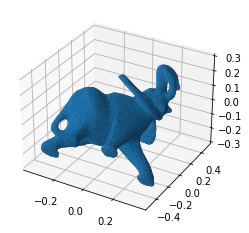

In [49]:
def plot_mesh_mpl(mesh):
    verts, faces = mesh.to_polygon_soup()
    ax = plt.figure().add_subplot(projection='3d')
    ax.plot_trisurf(verts[:, 0], verts[:, 1], verts[:, 2], triangles=faces)
    
plot_mesh_mpl(mesh)

If [meshplot](https://skoch9.github.io/meshplot/tutorial/) is installed:

In [52]:
import meshplot as mp

def plot_mesh_mp(mesh):
    verts, faces = mesh.to_polygon_soup()
    mp.plot(verts.astype('single'), faces)  # Seems like meshplot doesn't like doubles
    
plot_mesh_mp(mesh)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

Or [pyvista](https://www.pyvista.org/):

In [53]:
from pyvista import PolyData, set_jupyter_backend
set_jupyter_backend('pythreejs')

def plot_mesh_pv(mesh):
    verts, faces = mesh.to_polygon_soup()
    # Pyvista face array needs cell sizes, assume triangles
    assert faces.shape[1] == 3
    pv_faces = concatenate([3 * ones((mesh.n_faces, 1), dtype='int'), faces.astype('int')], axis=1)
    pv_mesh = PolyData(verts, faces=pv_faces)
    pv_mesh.plot()
    
plot_mesh_pv(mesh)

Renderer(camera=PerspectiveCamera(aspect=1.3333333333333333, children=(DirectionalLight(color='#fefefe', inten…

Alternatively, the `.write_ply(filename)` and `.write_off(filename)` can be used to save the mesh to disk to a `.ply` or `.off` file, respectively.

## Boolean operations on surface meshes

The main operations from CGAL's [Polygon mesh processing module](https://doc.cgal.org/latest/Polygon_mesh_processing/index.html) are supported: `union`, `intersection`, and `difference`, all of which return the resulting mesh. The lower level `corefine` method corefines the input meshes inplace, and returns nothing.

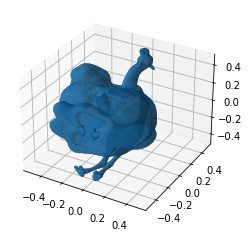

In [64]:
mesh1 = Mesh(r"C:\Users\14436\Documents\python\cgal\Data\data\meshes\bunny00.off")
mesh2 = Mesh(r"C:\Users\14436\Documents\python\cgal\Data\data\meshes\camel.off")
result = mesh1.union(mesh2)
plot_mesh_mpl(result)

## Referencing vertices and faces
The `.vertices` and `.faces` properties return a list of vertex and face handles, to be used in the subsequent mesh processing methods.

## Mesh processing

The following polygon mesh processing methods are implemented:

```python
mesh.remesh(faces: List[Face], target_edge_length: float, n_iter: int)
```

> Performs [isotropic remeshing](https://doc.cgal.org/latest/Polygon_mesh_processing/group__PMP__meshing__grp.html#gad3d03890515ae8103bd32a30a3486412) on the specified faces. This operation sequentially performs edge splits, edge collapses, edge flips, tangential relaxation and projection to the initial surface to generate a smooth mesh with a prescribed edge length. If `target_edge_length` = 0, then only the edge-flip, tangential relaxation, and projection steps will be done.

```python
mesh.fair(vertices: List[Vertex], continuity: int)
```

> Performs [fairing](https://doc.cgal.org/latest/Polygon_mesh_processing/group__PMP__meshing__grp.html#gaa091c8368920920eed87784107d68ecf) on the specified vertices. The continuity argument is 0, 1, or 2, refering to $C^0$, $C^1$ and $C^2$ continuity.

```python
mesh.refine(faces: List[Face], density: float)
```

> [Refines](https://doc.cgal.org/latest/Polygon_mesh_processing/group__PMP__meshing__grp.html#gad0449d8e1021fc46507074cd6db65ef4) the specified faces. The density parameter specifies the ratio $|F|_{new} : |F|_{old}$, so larger values yield higher refinements.

```python
mesh.smooth_mesh(faces: List[Face], n_iter: int, use_safety_constraints: bool)
```

> [Smooths](https://doc.cgal.org/latest/Polygon_mesh_processing/group__PMP__meshing__grp.html#gaa0551d546f6ab2cd9402bea12d8332a3) the mesh by attempting to make the triangle angle and area distributions as uniform as possible by moving (non-constrained) vertices. If use_safety_constraints is True, vertex moves that would worsen the mesh are ignored.

```python
mesh.smooth_shape(faces: List[Face], n_iter: int, time: float)
```
    
> [Smooths](https://doc.cgal.org/latest/Polygon_mesh_processing/group__PMP__meshing__grp.html#gaaa083ec78bcecf351e04d1bbf460b4a2) the mesh by using mean curvature flow. The `time` parameter specifies the step-size by which the surface is smoothed. A larger time step results in faster convergence but details may be distorted to a larger extent compared to more iterations with a smaller step. Typical values scale in the interval (1e-6, 1].
            

    
    

## Property maps

Property maps are added with 

```python
pmap = mesh.add_vertex_property(name: str, default_val: Union[int, float, bool])
pmap = mesh.add_face_property(name: str, default_val: Union[int, float, bool])
..., etc
```

where the type of `default_val` determines the type of the property map. The returned property map allows getting and setting values by indexing with the corresponding Vertex/Face/etc handles, either as scalars, lists, or arrays, e.g.

```python
pmap[mesh.vertices] = arange(mesh.n_vertices)
flipped_idxs = pmap[mesh.vertices[::-1]]
```